In [1]:
import torch
from matplotlib import pyplot as plt
import torch.optim as optim
import numpy as np
import timeit
from sklearn.model_selection import train_test_split

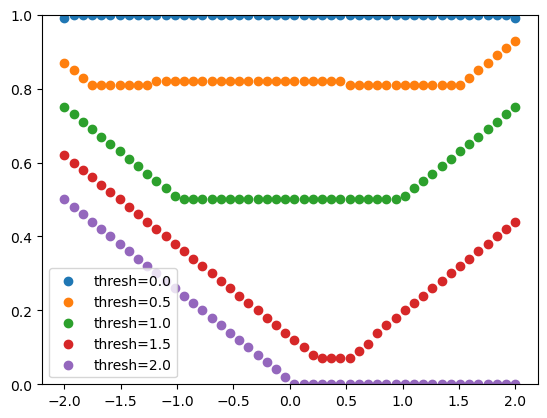

In [2]:
# Define Noisy Objective Function
def expensive_function(x):
    """The 1st column of x gives the nominal inputs, 2nd column gives the input noise"""
    noised_x = torch.sum(x, dim=1)
    noised_value = torch.where(noised_x >= 0, torch.sqrt(noised_x), -noised_x)
    # Add some additional noise we want to capture
    '''Turn it off'''
    std = 0; mu = torch.zeros(x.shape[0])
    extra_noise = torch.normal(mean=mu, std=std)
    '''Homoscedastic normal'''
    # std = 0.2
    # mu = torch.zeros(x.shape[0])
    # extra_noise = torch.normal(mean=mu, std=std)
    '''Heteroscedaistic normal'''
    # std = torch.sqrt(torch.abs(x[:,0])) / 2
    # mu = torch.zeros(x.shape[0])
    # extra_noise = torch.normal(mean=mu, std=std)
    '''Homoscedastic lognormal'''
    # extra_noise = torch.empty(x.shape[0]).log_normal_(-2, 1)
    '''Heteroscedastic & non-Gaussian noise'''
    # scale = 0.1 + 0.3 * torch.abs(torch.sin(5 * noised_x))  # heteroscedasticity
    # # Non-normal noise: mixture of Uniform and Laplace
    # lap = torch.distributions.Laplace(loc=0.0, scale=scale)
    # unif = torch.distributions.Uniform(-scale, scale)
    # mixing = torch.distributions.Bernoulli(probs=0.5).sample(noised_x.shape)
    # extra_noise = torch.where(mixing.bool(), lap.sample(), unif.sample())
    return noised_value + extra_noise

# Define computation of 'true' robustness measure by brute force sampling
def robust_measures(x_design, robustness_thresh, eps=2, num_eps_samples=100, num_repeats=100):
    robust_measures = torch.empty((x_design.shape[0], 1))
    for i, x_d in enumerate(x_design):
        x = torch.empty((num_eps_samples, 2))
        x[:,0] = x_d.repeat(num_eps_samples)
        x[:,1] = torch.linspace(-eps, eps, num_eps_samples)
        x = x.repeat((num_repeats,1))
        robust_measure = torch.sum(expensive_function(x) > robustness_thresh) / len(x)
        robust_measures[i] = robust_measure
    return robust_measures

EPS = 2
x_design = torch.linspace(-EPS, EPS, 50)

# Check out robustness measure at different thresholds
for robustness_thresh in torch.linspace(0,2,5):
    true_robust_measures = robust_measures(x_design, robustness_thresh=robustness_thresh, 
                                           eps=EPS, num_eps_samples=100, num_repeats=100)
    
    plt.scatter(x_design, true_robust_measures, label=f'thresh={torch.round(robustness_thresh, decimals=2)}')
    plt.ylim(0, 1);
    plt.legend()

# Use threshold with a clear minimum for testing
ROBUSTNESS_THRESH = 1.5
true_robust_measures = robust_measures(x_design, robustness_thresh=ROBUSTNESS_THRESH, 
                                       eps=EPS, num_eps_samples=500, num_repeats=500)

# Generate training data for NN
NUM_TRAIN = 100
# NUM_TRAIN = 275
# NUM_TRAIN = 500
# NUM_TRAIN = 100_000
NUM_TRAIN_REPEATS = 1
train_x = torch.empty(NUM_TRAIN, 2)
train_x[:,0].uniform_(-2,2)
# train_x[:,0] = torch.linspace(-2, 2, NUM_TRAIN)
train_x[:,1].uniform_(-EPS, EPS)
train_x = train_x.repeat((NUM_TRAIN_REPEATS,1)) # Generate repeats of the initial points to help learn variance
train_y  = expensive_function(train_x)
train_x, val_x, train_y, val_y = train_test_split(
    train_x, train_y, test_size=0.1, random_state=42
)

In [ ]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0, restore_best=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best = restore_best
        self.counter = 0
        self.best_loss = float('inf')
        self.best_state = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.restore_best:
                self.best_state = {k: v.clone() for k, v in model.state_dict().items()}
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def restore(self, model):
        if self.best_state is not None:
            model.load_state_dict(self.best_state)

models = {}
num_models = 3
for model_i in range(num_models):
    if model_i == 0:
        from NN_deterministic import *
        # NUM_EPOCHS = 6_000
        # NUM_EPOCHS = 2_000
        PENALTY_WEIGHT = 1e-12
        COMPLEXITY_COST_WEIGHT = None
        PATIENCE = 100
        models.update({str(model_i): {}})
        models[str(model_i)]['label'] = 'deterministic NN'
    elif model_i == 1:
        # from NN_bayesian import *
        from NN_bayesianfaster import *
        # NUM_EPOCHS = 1_500
        PENALTY_WEIGHT = None
        COMPLEXITY_COST_WEIGHT = 1e-6
        PATIENCE = 500
        models.update({str(model_i): {}})
        models[str(model_i)]['label'] = 'bayesian NN'
    elif model_i == 2:
        from MDN import *
        # NUM_EPOCHS = 1_500
        PATIENCE = 150
        models.update({str(model_i): {}})
        models[str(model_i)]['label'] = 'MDN'
    SAMPLE_NBR = 1
    NUM_EPOCHS = 6000
    HIDDEN_DIM = 50

    model = NN(input_dim=train_x.shape[1], hidden_dim = HIDDEN_DIM)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print(f"training model {models[str(model_i)]['label']}")
    early_stopper = EarlyStopping(patience=PATIENCE, min_delta=1e-6)
    for epoch in range(NUM_EPOCHS):
        model.train()
        optimizer.zero_grad()

        train_loss = loss_fn(model, train_x, train_y, sample_nbr=SAMPLE_NBR, 
                             complexity_cost_weight=COMPLEXITY_COST_WEIGHT,
                             penalty_weight=PENALTY_WEIGHT)
        train_loss.backward()
        optimizer.step()

        # Validation step
        model.eval()
        with torch.no_grad():
            val_loss = loss_fn(model, val_x, val_y, sample_nbr=SAMPLE_NBR,
                               complexity_cost_weight=COMPLEXITY_COST_WEIGHT,
                               penalty_weight=PENALTY_WEIGHT)

        if epoch % (NUM_EPOCHS // 10) == 0:
            print(f"Epoch {epoch}: Train Loss = {train_loss.item():.4f} | Val Loss = {val_loss.item():.4f}")

        early_stopper(val_loss.item(), model)
        if early_stopper.early_stop:
            print(f"Early stopping at epoch {epoch}")
            break

    # Optionally restore best model
    # early_stopper.restore(model)
    models[str(model_i)]['trained_model'] = model

training model deterministic NN
Epoch 0: Train Loss = 180.4145 | Val Loss = 168.3557
Epoch 600: Train Loss = -0.0235 | Val Loss = -0.0197


0.5262529170140624 seconds for deterministic NN
0.5704405829310417 seconds for bayesian NN
0.20111829205416143 seconds for MDN


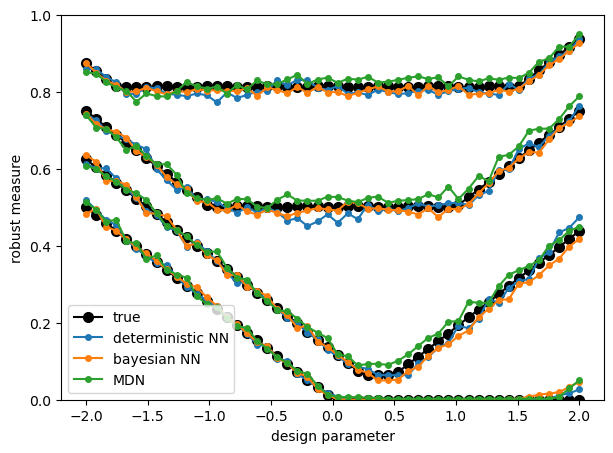

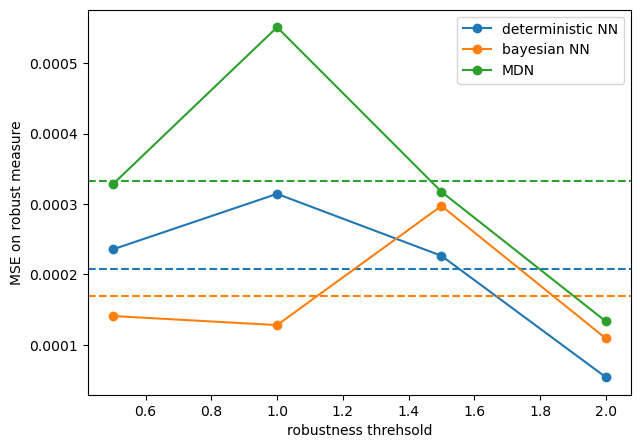

In [21]:
# Initialize a place to store MSE results
for model_i in range(num_models):
    models[str(model_i)]['all_mse'] = []

robustness_thresholds = torch.linspace(0.5,2,4)
fig, ax = plt.subplots(1, figsize=(7,5))
ax.set_ylim(0,1)
ax.set_ylabel('robust measure')
ax.set_xlabel('design parameter')
for thresh_i, robustness_thresh in enumerate(robustness_thresholds):
    true_robust_measures = robust_measures(x_design, robustness_thresh=robustness_thresh, 
                                           eps=EPS, num_eps_samples=500, num_repeats=500)
    ax.plot(x_design, true_robust_measures, marker='o', c='k', markersize=7, label=('true' if thresh_i==0 else '_'))

    for model_i in range(num_models):
        model = models[str(model_i)]['trained_model']
        model.eval()
        model_label = models[str(model_i)]['label'] if thresh_i==0 else '_'
        start_time = timeit.default_timer()
        with torch.no_grad():
            model_robust_measures = model.posterior_robust(x_design, robustness_thresh, num_eps_samples=2_000, eps=EPS,
                                                          n_mc_samples=50)
        if model_label != '_': 
            elapsed = timeit.default_timer() - start_time; print(f'{elapsed} seconds for {model_label}')
        mse = torch.square(torch.abs(model_robust_measures - true_robust_measures)).mean()
        models[str(model_i)]['all_mse'].append(mse)

        ax.plot(x_design, model_robust_measures, marker='o', markersize=4, 
                 label=f"{model_label}", color=f'C{model_i}')
        ax.legend()

fig, ax = plt.subplots(1, figsize=(7,5))
for model_i in range(num_models):
    ax.plot(robustness_thresholds, models[str(model_i)]['all_mse'], label=models[str(model_i)]['label'], 
            marker='o', color=f'C{model_i}')
    ax.axhline(np.mean(models[str(model_i)]['all_mse']), ls='--', color=f'C{model_i}')
ax.legend()
ax.set_xlabel('robustness threhsold')
ax.set_ylabel('MSE on robust measure');

- Relative accuracy can change significantly between training data sets, but not between retraining on same training set
- For no extra noise
    - Bayesian MSE seems more consistent wrt to retraining (on same training data) than Deterministic. Sometimes Deterministic spikes. 
    - Increase in model accuracy significantly diminishes above ~60 training points. 
    - Increasing complexity cost weight on Bayesian degrades accuracy. Decreasing no effect.
    - Changing penalty weight on Deterministic has no effect
- Overtraining (too many epochs) seems like an issue with Deterministic, not so much with Bayesian
- MDN consistently best performing on lognormal extra_noise (quite close to Bayesian if std is low, better if std is high, but in that case all models perform poorly)
- Bayesian best performing on heteroscedastic normal (MDN actually worst performing)
    - "while MDNs can represent heteroscedastic Gaussians, they do so less efficiently than a model that’s specifically designed for it"
- MDN and Bayesian about equal performance on heteroscedastic non-normal

In [63]:
test_x = torch.empty((50,2))
test_x[:,0].uniform_(-EPS,EPS)
test_x[:,1].uniform_(-EPS,EPS)

true_means = torch.empty(len(test_x))
true_stds = torch.empty(len(test_x))

for model_i in range(num_models):
    models[str(model_i)].update({'test_means': torch.empty(len(test_x))})
    models[str(model_i)].update({'test_stds': torch.empty(len(test_x))})

with torch.no_grad():
    for x_i, x in enumerate(test_x):
        x_repeats = x.repeat((100,1))
        
        test_y = expensive_function(x_repeats)
        true_means[x_i] = torch.mean(test_y)
        true_stds[x_i] = torch.std(test_y)
        
        for model_i in range(num_models):
            model = models[str(model_i)]['trained_model']
            if models[str(model_i)]['label'] == "MDN":
                means, variances = model.predict_mean_and_variance(x_repeats)
            else:
                means, variances = model(x_repeats)
            models[str(model_i)]['test_means'][x_i] = torch.mean(means)
            models[str(model_i)]['test_stds'][x_i] = torch.sqrt(torch.mean(variances))

for model_i in range(num_models):
    mse_means = torch.square(torch.abs(models[str(model_i)]['test_means'] - true_means)).mean()
    mse_stds = torch.square(torch.abs(models[str(model_i)]['test_stds'] - true_stds)).mean()
    print(f"{models[str(model_i)]['label']}: mse on means = {mse_means}, mse on stds = {mse_stds}")

deterministic NN: mse on means = 0.009179169312119484, mse on stds = 0.015913503244519234
bayesian NN: mse on means = 0.008331638760864735, mse on stds = 0.017578234896063805
MDN: mse on means = 0.012392360717058182, mse on stds = 0.024940259754657745


MSE on means doesn't change that dramatically when extra_noise is zero... meaning the problem with inferring the robustness measure lies in the variance inference?

In [19]:
for model_i in range(num_models):
    print(models[str(model_i)]['test_stds'])

tensor([0.2928, 0.1743, 0.3175, 0.2907, 0.1548, 0.2120, 0.2662, 0.2075, 0.1871,
        0.2744, 0.2667, 0.1849, 0.2725, 0.1645, 0.2876, 0.1603, 0.2237, 0.3108,
        0.1697, 0.2293, 0.3129, 0.2226, 0.1741, 0.2298, 0.2627, 0.2212, 0.2263,
        0.1441, 0.1909, 0.1462, 0.2890, 0.1446, 0.1816, 0.1911, 0.1976, 0.2999,
        0.2977, 0.2671, 0.2761, 0.3364, 0.1693, 0.1694, 0.1652, 0.1825, 0.2717,
        0.2135, 0.1472, 0.2581, 0.2815, 0.2297])
tensor([0.2891, 0.2500, 0.2031, 0.2561, 0.2527, 0.2325, 0.2328, 0.2645, 0.2691,
        0.2353, 0.2647, 0.2446, 0.2684, 0.2308, 0.2614, 0.2559, 0.2849, 0.2815,
        0.2434, 0.2413, 0.2450, 0.2734, 0.2633, 0.2284, 0.2564, 0.2517, 0.2685,
        0.2552, 0.2266, 0.2381, 0.2965, 0.2456, 0.2699, 0.2532, 0.2539, 0.1998,
        0.2802, 0.2799, 0.2963, 0.3119, 0.2366, 0.2604, 0.2521, 0.2495, 0.2980,
        0.2274, 0.2348, 0.3066, 0.2625, 0.2278])
tensor([0.0250, 0.1818, 0.0356, 0.0616, 0.0878, 0.0787, 0.1816, 0.0892, 0.1938,
        0.1115, 0.1296